In [1]:
# import pdb
import sys
import common
import argparse
import datasets
import numpy as np
import pandas as pd
import IPython as ip
from matplotlib import pyplot as plt
import estimators as estimators_lib
import itertools
import tensorflow as tf
import tensorflow_lattice as tfl
from LatticeCDF import LatticeCDF, execute_query

In [2]:
n = 100
df = pd.DataFrame({'col_0': np.random.permutation(range(1, n+1)), 'col_1': [np.random.choice(i)+1 for i in range(1, n+1)], 'col_2': [1]*(n//2) + [2]*(n//2)})
df

,col_0,col_1,col_2
0,62,1,1
1,32,1,1
2,22,3,1
3,30,2,1
4,90,1,1
...,...,...,...
95,89,86,2
96,57,97,2
97,73,96,2
98,24,37,2


In [3]:
df.to_csv("./datasets/test.csv", header=False, index=False)

In [46]:
# create wine2.csv
aaaa = pd.read_csv("./datasets/wine3.csv", header=None)
aaaa.columns=['col1', 'col2', 'col3']
aaaa[["col1", "col2"]].to_csv("./datasets/wine2.csv", header=None, index=None)

In [4]:
def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)

    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng,
                                                  dataset)
    sel = cal_true_card(
        (cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    vals = []
    # new_table = table.data.dropna(axis=0,how='any')
    new_table = table.data
    # print (248)
    s = new_table.iloc[rng.randint(0, new_table.shape[0])]
    vals = s.values
    # print (251)
    if dataset in ['dmv', 'dmv-tiny', 'order_line']:
        vals[6] = vals[6].to_datetime64()
    elif dataset in ['orders1', 'orders']:
        vals[4] = vals[4].to_datetime64()
    elif dataset == 'lineitem':
        vals[10] = vals[10].to_datetime64()
        vals[11] = vals[11].to_datetime64()
        vals[12] = vals[12].to_datetime64()
    # print (260)
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    # idxs = [12]
    cols = np.take(table.columns, idxs)
    # print (264)
    # print (cols)
    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    # ops = rng.choice(['<=', '>=', '='], size=num_filters)
    #ops = rng.choice(['<=', '>='], size=num_filters)
    ops = rng.choice(['<='], size=num_filters)
    #ops_all_eqs = ['='] * num_filters
    #sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    # print (271)
    #ops = np.where(sensible_to_do_range, ops, ops_all_eqs)
    # print (273)
    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals
    # print (276)
    vals = vals[idxs]
    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])
    # print (283)
    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values

In [2]:
def Oracle(table, query):
    cols, idxs, ops, vals = query
    oracle_est = estimators_lib.Oracle(table)

    return oracle_est.Query(cols, ops, vals)


def cal_true_card(query, table):
    cols, idxs, ops, vals = query
    ops = np.array(ops)
    probs = Oracle(table, (cols, idxs, ops, vals))
    return probs


def GenerateQuery(table, min_num_filters, max_num_filters, rng, dataset):
    """Generate a random query."""
    num_filters = rng.randint(max_num_filters - 1, max_num_filters)
    cols, idxs, ops, vals = SampleTupleThenRandom(table, num_filters, rng,
                                                  dataset)
    sel = cal_true_card(
        (cols, idxs, ops, vals), table) / float(table.cardinality)
    return cols, idxs, ops, vals, sel


def SampleTupleThenRandom(table, num_filters, rng, dataset):
    idxs = rng.choice(len(table.columns), replace=False, size=num_filters)
    cols = np.take(table.columns, idxs)

    # If dom size >= 10, okay to place a range filter.
    # Otherwise, low domain size columns should be queried with equality.
    # ops = rng.choice(['<=', '>=', '='], size=num_filters)
    # ops = rng.choice(['<=', '>'], size=num_filters)
    ops = rng.choice(['<='], size=num_filters)

    #     ops_all_eqs = ['='] * num_filters
    #     sensible_to_do_range = [c.DistributionSize() >= 10 for c in cols]
    #     ops = np.where(sensible_to_do_range, ops, ops_all_eqs)

    # if num_filters == len(table.columns):
    #     return table.columns,np.arange(len(table.columns)), ops, vals

    vals = []
    for i in range(num_filters):
        s = table.data.iloc[rng.randint(0, table.data.shape[0])]
        vals.append(s.values[idxs][i])

    vals = np.array(vals)

    op_a = []
    val_a = []
    for i in range(len(vals)):
        val_a.append([vals[i]])
        op_a.append([ops[i]])

    return cols, idxs, pd.DataFrame(op_a).values, pd.DataFrame(val_a).values

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset',
                    type=str,
                    default='wine2',
                    help='Dataset.')
parser.add_argument('--loss', type=str, default='MSE', help='Loss.')
parser.add_argument('--query-size',
                    type=int,
                    default=1000,
                    help='query size')
parser.add_argument('--num-conditions',
                    type=int,
                    default=2,
                    help='num of conditions')
parser.add_argument('--lr', type=float, default=1e-2, help='learning rate')
parser.add_argument('--bs', type=int, default=1000, help='Batch size.')
parser.add_argument('--lattice', type=int, default=3, help='Lattice size.')
parser.add_argument('--seed', type=int, default=4321, help='Random seed')
parser.add_argument('--sample',
                    type=int,
                    default=0,
                    help='reload trained mode')
parser.add_argument('--epochs',
                    type=int,
                    default=1000,
                    help='Number of epochs to train for.')
# args = parser.parse_args()
args, unknown = parser.parse_known_args()

In [4]:
bs = int(args.bs)
lr = float(args.lr)
epochs = int(args.epochs)
lattice = int(args.lattice)
sample = int(args.sample)

if args.dataset == 'dmv-tiny':
    table = datasets.LoadDmv('dmv-tiny.csv')
elif args.dataset == 'dmv':
    table = datasets.LoadDmv()
else:
    type_casts = {}
    if args.dataset in ['orders1']:
        type_casts = {4: np.datetime64, 5: np.float}
    elif args.dataset in ['orders']:
        type_casts = {4: np.datetime64}
    elif args.dataset == 'lineitem':
        type_casts = {
            10: np.datetime64,
            11: np.datetime64,
            12: np.datetime64
        }
    elif args.dataset == 'order_line':
        type_casts = {6: np.datetime64}

    table = datasets.LoadDataset(args.dataset + '.csv',
                                 args.dataset,
                                 type_casts=type_casts)
table_train = table
train_data = common.TableDataset(table_train)
query_set = None
print('Begin Generating Queries ...')
rng = np.random.RandomState(args.seed)
query_set = [
    GenerateQuery(table, 2, args.num_conditions + 1, rng, args.dataset)
    for i in range(args.query_size)
]
print('Complete Generating Queries.')

load dataset wine2.csv done
(6497, 2)
(6497, 2)
0
1
0 106
1 187
[31 36]
(6497, 2)
Begin Generating Queries ...
Complete Generating Queries.


In [5]:
def dictionary_column_interval(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    column_interval = {}
    for i in range(n_column):
        column_interval[i] = set()  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        col_idxs = query[1]
        vals = query[3]
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]
        else:
            column_interval[k] = sorted(list(v))
    return column_interval

In [6]:
def dictionary_column_variable(column_to_interval):
    # Assign a sequential index to each interval in each column
    column_to_variable = {}
    total_intervals = 0  # count how many intervals in total
    column_variable_number = []  # count how many intervals in each column
    for k, v in column_to_interval.items():
        count = len(v)
        column_to_variable[k] = [total_intervals + i for i in range(count)]
        total_intervals += count
        column_variable_number.append(count)
    return total_intervals, column_variable_number, column_to_variable

In [7]:
table_size = table.data.shape
n_row = table_size[0]
n_column = table_size[1]
column_to_interval = dictionary_column_interval(table_size, query_set)
total_intervals, column_variable_number, column_to_variable = dictionary_column_variable(column_to_interval)

In [8]:
column_variable_number

[75, 109]

In [9]:
train_X = []
train_Y = []
for query in query_set:
    x = [sys.maxsize] * n_column
    _, col_idxs, _, vals, sel = query
    for i in range(len(col_idxs)):
        x[col_idxs[i]] = vals[i][0]
    train_X.append(x)
    train_Y.append(table.data.shape[0] * sel)

train_X = np.array(train_X).astype(np.float32)
train_Y = np.array(train_Y).astype(np.float32).reshape(len(query_set),1) / table_size[0]

train = np.concatenate((train_X, train_Y), axis=1)
train = np.unique(train, axis=0)

train_X, train_Y = np.hsplit(train, [-1])

feat_mins = train_X.min(axis=0)
feat_maxs = train_X.max(axis=0)

data_train = pd.DataFrame(train, columns=[f'col_{i}' for i in range(train.shape[1]-1)] + ['sel'])

In [10]:
train_X.shape

(753, 2)

In [11]:
train_X

array([[ 4.4 ,  0.55],
       [ 4.5 ,  0.27],
       [ 4.5 ,  0.66],
       ...,
       [13.  ,  0.24],
       [13.3 ,  0.4 ],
       [13.7 ,  0.19]], dtype=float32)

In [12]:
train_Y

array([[1.07742031e-03],
       [6.15668774e-04],
       [1.23133755e-03],
       [2.15484062e-03],
       [3.07834387e-04],
       [1.38525479e-03],
       [2.46267510e-03],
       [4.61751595e-03],
       [5.07926755e-03],
       [7.69585953e-04],
       [3.23226093e-03],
       [6.61843922e-03],
       [6.15668774e-04],
       [1.23133755e-03],
       [1.53917191e-03],
       [2.46267510e-03],
       [3.23226093e-03],
       [1.13898721e-02],
       [2.46267510e-03],
       [3.23226093e-03],
       [6.46452187e-03],
       [1.18516237e-02],
       [1.73926428e-02],
       [2.30875798e-03],
       [2.30875798e-03],
       [3.07834381e-03],
       [8.61936249e-03],
       [1.67769734e-02],
       [1.81622282e-02],
       [2.01631524e-02],
       [3.69401253e-03],
       [1.33907953e-02],
       [1.87778976e-02],
       [1.97014008e-02],
       [7.23410817e-03],
       [8.15761089e-03],
       [1.12359552e-02],
       [2.12405734e-02],
       [3.00138518e-02],
       [3.35539468e-02],


In [16]:
# 要加一个最大值，让train_Y的最大值为1
# 把四周的边界补齐，这个可以做到，中间的点做不到, 补的时候可以用三次样条自动补嘛？样条可以保持单调性吗？可以在PWL直接改成三次样条吗

In [42]:
NUM_EPOCHS = 1000
BATCH_SIZE = 64
LEARNING_RATE=0.01

In [45]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_train,
    y=data_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    shuffle=False,
)

# feature_analysis_input_fn is used for TF Lattice estimators.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=data_train,
    y=data_train["sel"],
    batch_size=BATCH_SIZE,
    num_epochs=1,
    shuffle=False,
)

In [48]:
feature_columns = [
    tf.feature_column.numeric_column("col_0"),
    tf.feature_column.numeric_column("col_1"),
    tf.feature_column.numeric_column("col_2"),
]
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name="col_0",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        ),
        tfl.configs.FeatureConfig(
            name="col_1",
            lattice_size=2,
            monotonicity="increasing",
            pwl_calibration_num_keypoints=1000,
        )
    ])
tfl_estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42),
)
tfl_estimator.train(input_fn=train_input_fn)

In [50]:
from IPython.core.pylabtools import figsize

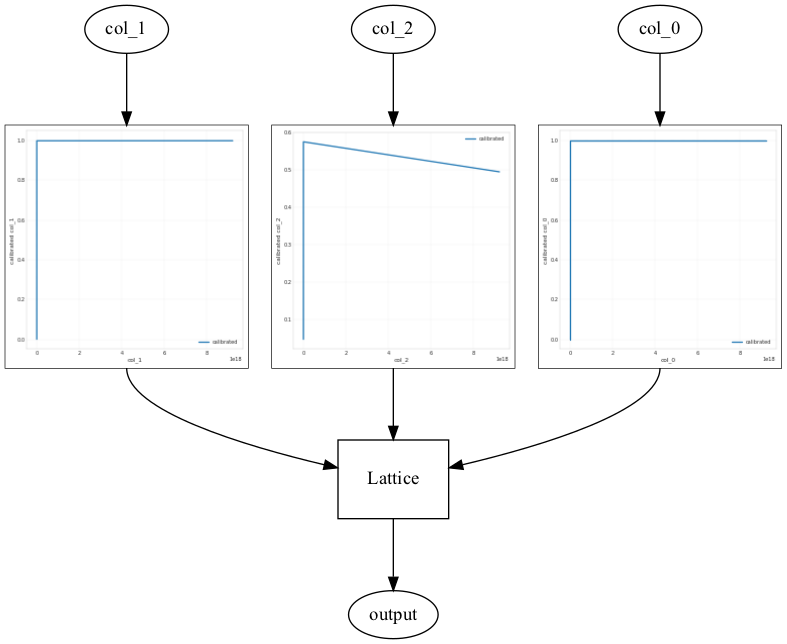

In [51]:
def save_and_visualize_lattice(tfl_estimator):
  saved_model_path = tfl_estimator.export_saved_model(
      "/tmp/TensorFlow_Lattice_101/",
      tf.estimator.export.build_parsing_serving_input_receiver_fn(
          feature_spec=tf.feature_column.make_parse_example_spec(
              feature_columns)))
  model_graph = tfl.estimators.get_model_graph(saved_model_path)
  figsize(8, 8)
  tfl.visualization.draw_model_graph(model_graph)
  return model_graph

_ = save_and_visualize_lattice(tfl_estimator)

In [21]:
def query_to_lattice_input(table_size, query_set):
    # Traverse all queries to apply the intervalization skill for each column
    n_column = table_size[1]
    x = [sys.maxsize] * n_column
    for i in range(n_column):
        column_interval[i] = set([0, sys.maxsize])  # use set([0, sys.maxsize]) to adapt '>' and '<'.
    for query in query_set:
        col_idxs = query[1]
        vals = query[3]
        for i in range(len(col_idxs)):
            column_interval[col_idxs[i]].add(vals[i][0])
    for k, v in column_interval.items():
        if not v:
            column_interval[k] = [0]
        else:
            column_interval[k] = sorted(list(v))
    return column_interval

In [22]:
data = table.data.to_numpy()

unique_vals = []
for i in range(data.shape[1]):
    unique_vals.append(np.unique(data[:, i]))

In [23]:
train_X = []
train_Y = []
for query in query_set:
    cols, idxs, ops, vals, sel = query
    x = []
    for i in range(data.shape[1]):
        if unique_vals[i][0] > 1:
            x.append(unique_vals[i][0] - 1)
        else:
            x.append(unique_vals[i][0] / 2)
        x.append(unique_vals[i][-1])
    for i in range(len(idxs)):
        if ops[i] == '<=':
            x[2 * idxs[i] + 1] = vals[i]
        if ops[i] == '>=':
            index = np.searchsorted(unique_vals[idxs[i]], vals[i])
            if index > 0:
                x[2 * idxs[i]] = unique_vals[idxs[i]][index - 1]
            else:
                if unique_vals[idxs[i]][0] > 1:
                    x[2 * idxs[i]] = unique_vals[idxs[i]][0] - 1
                else:
                    x[2 * idxs[i]] = unique_vals[idxs[i]][0] / 2
        if ops[i] == '=':
            x[2 * idxs[i] + 1] = vals[i]
            index = np.searchsorted(unique_vals[idxs[i]], vals[i])
            if index > 0:
                x[2 * idxs[i]] = unique_vals[idxs[i]][index - 1]
            else:
                if unique_vals[idxs[i]][0] > 1:
                    x[2 * idxs[i]] = unique_vals[idxs[i]][0] - 1
                else:
                    x[2 * idxs[i]] = unique_vals[idxs[i]][0] / 2
    train_X.append(x)
    train_Y.append(data.shape[0] * sel)

train_X = np.array(train_X).astype(np.float32)
train_Y = np.array(train_Y).astype(np.float32).reshape(len(query_set),1)

# train_X = train_X[train_Y != 0]
# train_Y = train_Y[train_Y != 0]

train = np.concatenate((train_X, train_Y), axis=1)
train = np.unique(train, axis=0)
train_X, train_Y = np.hsplit(train, [-1])

In [24]:
train_col = []
for i in range(data.shape[1]):
    train_col.append(train_X[:, i * 2:(i + 1) * 2])

feat_mins = [x.min() for x in train_col]
feat_maxs = [x.max() for x in train_col]

In [13]:
m = LatticeCDF(args.dataset + '_' + args.loss, lattice, feat_mins,
               feat_maxs, table.data.shape[0], pwl_calibration_input_keypoints=column_to_interval)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
col_0 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
col_1 (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
pwl_calibration (PWLCalibration (None, 1)            75          col_0[0][0]                      
__________________________________________________________________________________________________
pwl_calibration_1 (PWLCalibrati (None, 1)            109         col_1[0][0]                      
______________________________________________________________________________________________

In [14]:
m.fit(train_X, train_Y, lr=lr, bs=bs, epochs=epochs, loss=args.loss)

Train on 753 samples
Epoch 1/1000
753/753 [==============================] - 1s 849us/sample - loss: 0.0267
Epoch 2/1000
753/753 [==============================] - 0s 6us/sample - loss: 0.0325
Epoch 3/1000
753/753 [==============================] - 0s 12us/sample - loss: 0.0224
Epoch 4/1000
753/753 [==============================] - 0s 11us/sample - loss: 0.0181
Epoch 5/1000
753/753 [==============================] - 0s 5us/sample - loss: 0.0185
Epoch 6/1000
753/753 [==============================] - 0s 10us/sample - loss: 0.0172
Epoch 7/1000
753/753 [==============================] - 0s 11us/sample - loss: 0.0140
Epoch 8/1000
753/753 [==============================] - 0s 11us/sample - loss: 0.0113
Epoch 9/1000
753/753 [==============================] - 0s 10us/sample - loss: 0.0102
Epoch 10/1000
753/753 [==============================] - 0s 10us/sample - loss: 0.0096
Epoch 11/1000
753/753 [==============================] - 0s 12us/sample - loss: 0.0088
Epoch 12/1000
753/753 [=========

Epoch 94/1000
753/753 [==============================] - 0s 11us/sample - loss: 5.6385e-04
Epoch 95/1000
753/753 [==============================] - 0s 10us/sample - loss: 5.6139e-04
Epoch 96/1000
753/753 [==============================] - 0s 10us/sample - loss: 5.5913e-04
Epoch 97/1000
753/753 [==============================] - 0s 10us/sample - loss: 5.5700e-04
Epoch 98/1000
753/753 [==============================] - 0s 10us/sample - loss: 5.5491e-04
Epoch 99/1000
753/753 [==============================] - 0s 11us/sample - loss: 5.5285e-04
Epoch 100/1000
753/753 [==============================] - 0s 10us/sample - loss: 5.5088e-04
Epoch 101/1000
753/753 [==============================] - 0s 11us/sample - loss: 5.4903e-04
Epoch 102/1000
753/753 [==============================] - 0s 10us/sample - loss: 5.4720e-04
Epoch 103/1000
753/753 [==============================] - 0s 11us/sample - loss: 5.4546e-04
Epoch 104/1000
753/753 [==============================] - 0s 11us/sample - loss: 5.437

753/753 [==============================] - 0s 10us/sample - loss: 4.6026e-04
Epoch 184/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.5957e-04
Epoch 185/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5888e-04
Epoch 186/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5820e-04
Epoch 187/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5753e-04
Epoch 188/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5687e-04
Epoch 189/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5622e-04
Epoch 190/1000
753/753 [==============================] - 0s 12us/sample - loss: 4.5557e-04
Epoch 191/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5494e-04
Epoch 192/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.5431e-04
Epoch 193/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.5367e-04
Epo

Epoch 273/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.2174e-04
Epoch 274/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.2150e-04
Epoch 275/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.2126e-04
Epoch 276/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.2102e-04
Epoch 277/1000
753/753 [==============================] - 0s 12us/sample - loss: 4.2079e-04
Epoch 278/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.2056e-04
Epoch 279/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.2034e-04
Epoch 280/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.2012e-04
Epoch 281/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.1990e-04
Epoch 282/1000
753/753 [==============================] - 0s 21us/sample - loss: 4.1968e-04
Epoch 283/1000
753/753 [==============================] - 0s 19us/sample - loss:

753/753 [==============================] - 0s 11us/sample - loss: 4.0774e-04
Epoch 363/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.0762e-04
Epoch 364/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.0751e-04
Epoch 365/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.0740e-04
Epoch 366/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.0729e-04
Epoch 367/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.0718e-04
Epoch 368/1000
753/753 [==============================] - 0s 10us/sample - loss: 4.0708e-04
Epoch 369/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.0697e-04
Epoch 370/1000
753/753 [==============================] - 0s 12us/sample - loss: 4.0687e-04
Epoch 371/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.0676e-04
Epoch 372/1000
753/753 [==============================] - 0s 11us/sample - loss: 4.0666e-04
Epo

Epoch 452/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9986e-04
Epoch 453/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9979e-04
Epoch 454/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9972e-04
Epoch 455/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9965e-04
Epoch 456/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9959e-04
Epoch 457/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9952e-04
Epoch 458/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9945e-04
Epoch 459/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9938e-04
Epoch 460/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9931e-04
Epoch 461/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9924e-04
Epoch 462/1000
753/753 [==============================] - 0s 10us/sample - loss:

753/753 [==============================] - 0s 11us/sample - loss: 3.9415e-04
Epoch 542/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9410e-04
Epoch 543/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9404e-04
Epoch 544/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9398e-04
Epoch 545/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9393e-04
Epoch 546/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9387e-04
Epoch 547/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9381e-04
Epoch 548/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.9376e-04
Epoch 549/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9370e-04
Epoch 550/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9365e-04
Epoch 551/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.9359e-04
Epo

Epoch 631/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8943e-04
Epoch 632/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8939e-04
Epoch 633/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8934e-04
Epoch 634/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8929e-04
Epoch 635/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8924e-04
Epoch 636/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8919e-04
Epoch 637/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8914e-04
Epoch 638/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8909e-04
Epoch 639/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8904e-04
Epoch 640/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8899e-04
Epoch 641/1000
753/753 [==============================] - 0s 10us/sample - loss:

753/753 [==============================] - 0s 10us/sample - loss: 3.8526e-04
Epoch 721/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8521e-04
Epoch 722/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8517e-04
Epoch 723/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8513e-04
Epoch 724/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8508e-04
Epoch 725/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8504e-04
Epoch 726/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8499e-04
Epoch 727/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8495e-04
Epoch 728/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8490e-04
Epoch 729/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8486e-04
Epoch 730/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8481e-04
Epo

Epoch 810/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8140e-04
Epoch 811/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8135e-04
Epoch 812/1000
753/753 [==============================] - 0s 33us/sample - loss: 3.8131e-04
Epoch 813/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.8127e-04
Epoch 814/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8123e-04
Epoch 815/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8119e-04
Epoch 816/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8115e-04
Epoch 817/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8111e-04
Epoch 818/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8107e-04
Epoch 819/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.8103e-04
Epoch 820/1000
753/753 [==============================] - 0s 10us/sample - loss:

753/753 [==============================] - 0s 11us/sample - loss: 3.7788e-04
Epoch 900/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7784e-04
Epoch 901/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7780e-04
Epoch 902/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7776e-04
Epoch 903/1000
753/753 [==============================] - 0s 19us/sample - loss: 3.7773e-04
Epoch 904/1000
753/753 [==============================] - 0s 15us/sample - loss: 3.7769e-04
Epoch 905/1000
753/753 [==============================] - 0s 12us/sample - loss: 3.7765e-04
Epoch 906/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7761e-04
Epoch 907/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7757e-04
Epoch 908/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7754e-04
Epoch 909/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7750e-04
Epo

Epoch 989/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7461e-04
Epoch 990/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7457e-04
Epoch 991/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7454e-04
Epoch 992/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7450e-04
Epoch 993/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7447e-04
Epoch 994/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7443e-04
Epoch 995/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7440e-04
Epoch 996/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7436e-04
Epoch 997/1000
753/753 [==============================] - 0s 10us/sample - loss: 3.7433e-04
Epoch 998/1000
753/753 [==============================] - 0s 11us/sample - loss: 3.7430e-04
Epoch 999/1000
753/753 [==============================] - 0s 10us/sample - loss:

In [35]:
pred = m.model.predict(np.hsplit(train_X, train_X.shape[1]))

In [36]:
pred.shape

(247, 1)

In [ ]:
# generate table

In [15]:
df_grid = pd.DataFrame(
    columns=[f'col_{i}' for i in range(n_column)],
    index=[i for i in range(np.prod(column_variable_number))]
)

column_to_x = []
for i in column_variable_number:
    column_to_x.append([j for j in range(i)])

all_x = np.array([x for x in itertools.product(*column_to_x)], dtype=np.uint16)
for i in range(all_x.shape[0]):
    df_grid.iloc[i, :] = [column_to_interval[j][all_x[i][j]] for j in range(n_column)]

In [16]:
df_grid

,col_0,col_1
0,4.4,0.1
1,4.4,0.11
2,4.4,0.12
3,4.4,0.13
4,4.4,0.135
...,...,...
8170,13.7,0.96
8171,13.7,0.965
8172,13.7,1.035
8173,13.7,1.13


In [17]:
df_grid = np.array(df_grid).astype(np.float32)

In [18]:
df_grid

array([[ 4.4  ,  0.1  ],
       [ 4.4  ,  0.11 ],
       [ 4.4  ,  0.12 ],
       ...,
       [13.7  ,  1.035],
       [13.7  ,  1.13 ],
       [13.7  ,  1.33 ]], dtype=float32)

In [19]:
pred = m.model.predict(np.hsplit(df_grid, df_grid.shape[1]))

In [20]:
pred

array([[0.       ],
       [0.       ],
       [0.       ],
       ...,
       [0.9779166],
       [0.9779166],
       [0.9779166]], dtype=float32)

In [21]:
column_variable_number

[75, 109]

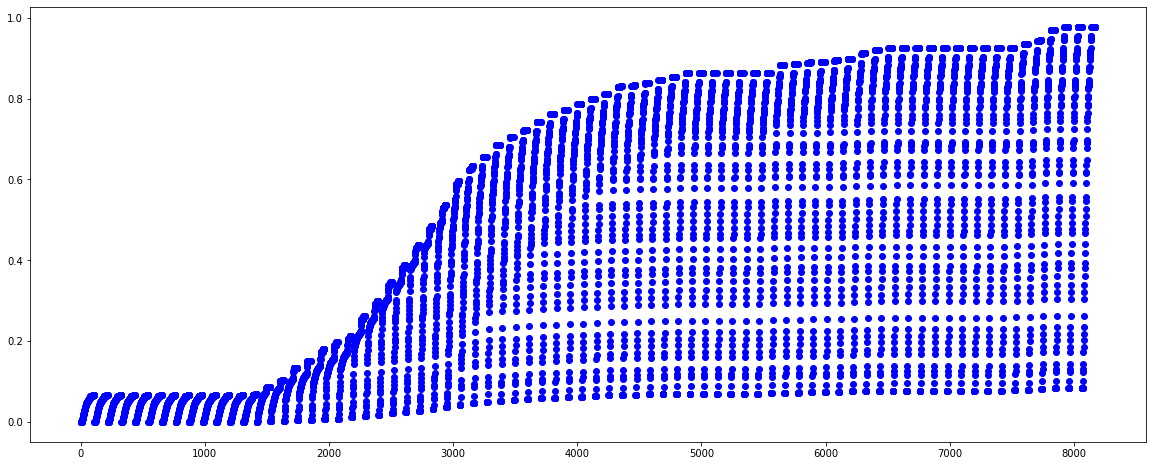

In [22]:
plt.figure(figsize=(20,8))
plt.plot(pred, 'bo')

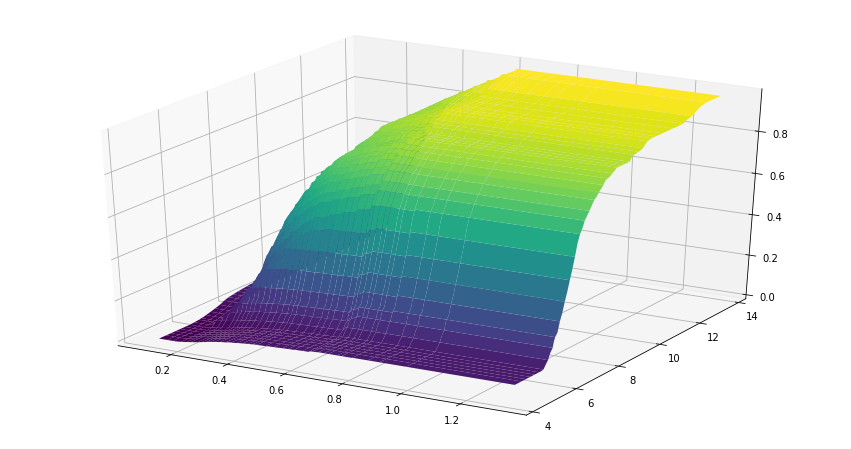

In [23]:
fig = plt.figure(figsize=(15,8))
ax3 = plt.axes(projection='3d')

xx = column_to_interval[1]
yy = column_to_interval[0]
X, Y = np.meshgrid(xx, yy)

# X = df_grid[:, 1].reshape(column_variable_number[0], column_variable_number[1])  # 这样也可以
# Y = df_grid[:, 0].reshape(column_variable_number[0], column_variable_number[1])
Z = pred.reshape(column_variable_number[0], column_variable_number[1])

ax3.plot_surface(X, Y, Z, cmap='viridis')

#ax3.contourf(X,Y,Z,zdir='z', offset=-2,cmap="viridis")  #生成z方向投影，投到x-y平面
#ax3.contourf(X,Y,Z,zdir='x', offset=0,cmap="viridis")  #生成x方向投影，投到y-z平面
#ax3.contourf(X,Y,Z,zdir='y', offset=15,cmap="viridis")   #生成y方向投影，投到x-z平面
# contourf()实心函数，contour函数只画等高线

# #设定显示范围
# ax3.set_xlabel('X')
# ax3.set_xlim(0, 0.7)

# ax3.set_ylabel('Y')
# ax3.set_ylim(5, 15)

# ax3.set_zlabel('Z')
# ax3.set_zlim(-2, 1)

plt.show()

In [28]:
#from matplotlib import ticker, cm

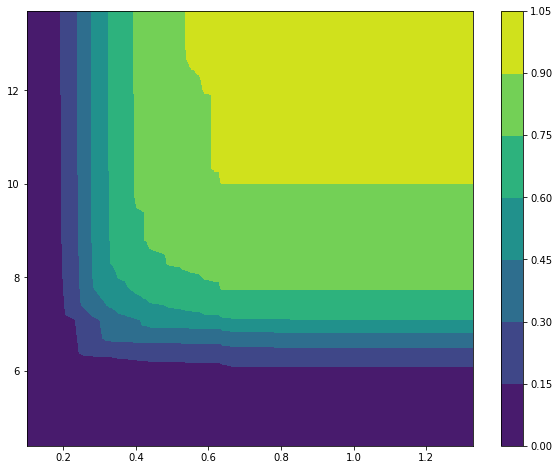

In [24]:
#fig, ax = plt.subplots()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

cs = ax.contourf(X, Y, Z, cmap='viridis')

# Alternatively, you can manually set the levels
# and the norm:
# lev_exp = np.arange(np.floor(np.log10(z.min())-1),
#                    np.ceil(np.log10(z.max())+1))
# levs = np.power(10, lev_exp)
# cs = ax.contourf(X, Y, z, levs, norm=colors.LogNorm())

cbar = fig.colorbar(cs)

plt.show()

In [30]:
# 画一下原生的图做对比，是否需要更光滑
# 变得光滑：
# 1. 数据预处理，缩放，标准化
# 2. 凸函数
# 3. lattice正则器

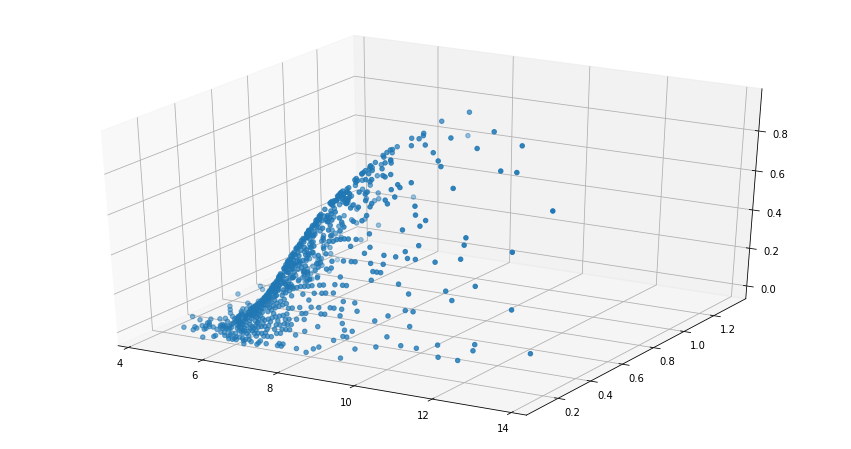

In [25]:
# query 对网格的覆盖率 散点图
fig = plt.figure(figsize=(15,8))
ax1 = plt.axes(projection='3d')
z = train_Y
x = train_X[:, 0]
y = train_X[:, 1]
ax1.scatter3D(x,y,z, cmap='b')
plt.show()

In [32]:
xtick = column_to_interval[0]
ytick = column_to_interval[1]

In [26]:
xtick = np.unique(train_X[:, 0])
ytick = np.unique(train_X[:, 1])

In [27]:
train_X.shape

(753, 2)

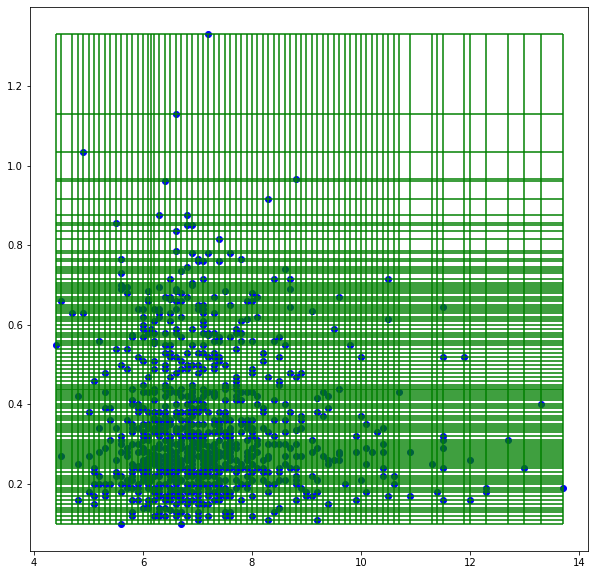

In [28]:
# query 对网格的覆盖率 散点图
fig = plt.figure(figsize=(10,10))
plt.scatter(train_X[:, 0], train_X[:, 1], c='b')
# plt.xticks(np.arange(xtick.min(), xtick.max(), 0.1))
# plt.yticks(np.arange(ytick.min(), ytick.max(), 0.01))
plt.vlines(xtick, ytick.min(), ytick.max(), colors = "green")
plt.hlines(ytick, xtick.min(), xtick.max(), colors = "green")
plt.show()

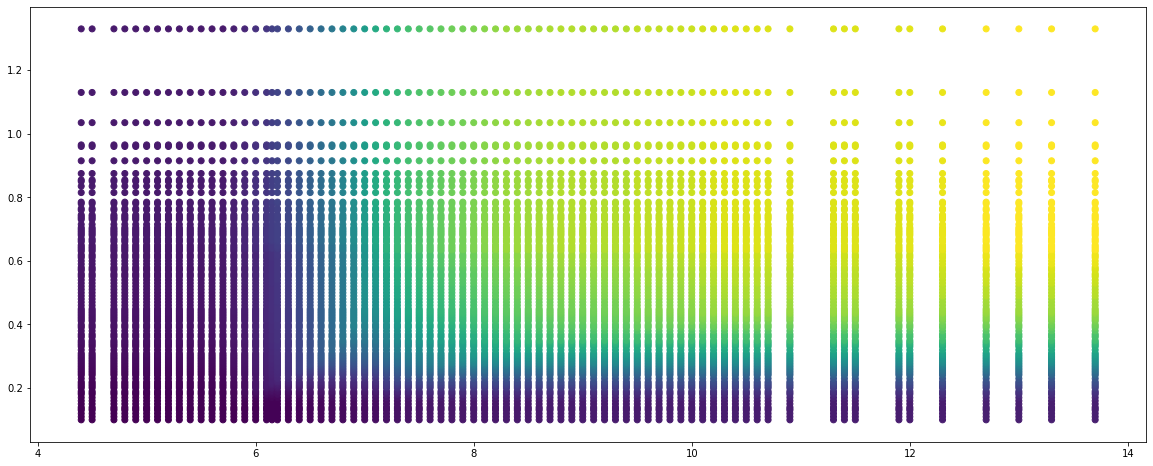

In [29]:
fig = plt.figure(figsize=(20, 8))
plt.scatter(df_grid[:, 0], df_grid[:, 1], c=pred.ravel())

In [68]:
t = df_grid.reshape(-1, 2, 3)
print(t.shape)
t

(4700, 2, 3)


array([[[  1.,   1.,   1.],
        [  1.,   1.,   2.]],

       [[  1.,   2.,   1.],
        [  1.,   2.,   2.]],

       [[  1.,   3.,   1.],
        [  1.,   3.,   2.]],

       ...,

       [[100.,  79.,   1.],
        [100.,  79.,   2.]],

       [[100.,  80.,   1.],
        [100.,  80.,   2.]],

       [[100.,  93.,   1.],
        [100.,  93.,   2.]]], dtype=float32)

In [69]:
#np.diff(df_grid.reshape(-1, 2, 3), axis=1)
tt = t[:, 1, :] - t[:, 0, :]
print(tt.shape)
tt

(4700, 3)


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [70]:
a = pred.reshape(-1, 2)
print(a.shape)
a

(4700, 2)


array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.56452435, 0.9693535 ],
       [0.56555194, 0.9712853 ],
       [0.56555194, 0.9712853 ]], dtype=float32)

In [71]:
aa = a[:, 1] - a[:, 0]
print(aa.shape)
aa

(4700,)


array([0.        , 0.        , 0.        , ..., 0.40482914, 0.40573335,
       0.40573335], dtype=float32)

In [72]:
sum(aa<0)

0

In [167]:
# 检查每一个维度都是单调增的CDF
error = 0
for i in range(df_grid.shape[0]):
    a,b,c = df_grid[i]
    
    # 检查第三个维度
    if c == 2:
        if pred[i] - pred[i-1]<0:
            error += 1

    # 检查第二个维度
    if c == 1 and i+2<df_grid.shape[0]:
        if df_grid[i+2][0] == a and pred[i+2] - pred[i]<0:
            error+=1
    if c == 2 and i+2<df_grid.shape[0]:
        if df_grid[i+2][0] == a and pred[i+2] - pred[i]<0:
            error+=1

    # 检查第一个维度
    if i + 94 < df_grid.shape[0]:
        d,e,f = df_grid[i+94]
        if d-a==1 and e==b and f==c and pred[i+94]-pred[i]<0:
            error+=1



#     if i % 3 == 1:
#         print(df_grid[i])
#         print(df_grid[i-94])

#         if pred[i] - pred[i-2] < 0:
#             if pred[i][0] == pred[i-2][0]:
#                 error +=1
#             print(df_grid[i-2], pred[i-2])
#             print(df_grid[i], pred[i])
print(error)
        
#     a,b,c = df_grid[i]
#     if c==1:
#         print(i)

0


In [121]:
new = df_grid.reshape(-1, column_variable_number[-1], 3)
new

array([[[  1.,   1.,   1.],
        [  1.,   1.,   2.]],

       [[  1.,   2.,   1.],
        [  1.,   2.,   2.]],

       [[  1.,   3.,   1.],
        [  1.,   3.,   2.]],

       ...,

       [[100.,  79.,   1.],
        [100.,  79.,   2.]],

       [[100.,  80.,   1.],
        [100.,  80.,   2.]],

       [[100.,  93.,   1.],
        [100.,  93.,   2.]]], dtype=float32)

In [122]:
test = np.diff(pred.reshape(-1, column_variable_number[-1]), axis=1)
print(test)

[[0.        ]
 [0.        ]
 [0.        ]
 ...
 [0.40482914]
 [0.40573335]
 [0.40573335]]


In [169]:
flip = np.flip(np.array(column_variable_number + [1]))
find = np.flip(flip.cumprod())[1:]
find

array([94,  2,  1])

In [170]:
feat_mins = []
for i in range(n_column):
    feat_mins.append(column_to_interval[i][0])
feat_mins

[1, 1, 1]

In [171]:
from copy import deepcopy

In [172]:
flip = np.flip(np.array(column_variable_number + [1]))
find = np.flip(flip.cumprod())[1:]

newpred = deepcopy(pred)
for i in range(df_grid.shape[0]):
    x, y = df_grid[i], float(pred[i])
    for j in range(n_column):
        if x[j] != feat_mins[j]:  # x[j] 此时不是自己这一列中最小的需要做减法
            y -= float(pred[i-find[j]])  # 做减法，返回减法后的
    newpred[i] = y

In [173]:
sum(newpred <0)

array([8896])

In [174]:
newpred

array([[ 0.       ],
       [ 0.       ],
       [ 0.       ],
       ...,
       [-1.5174277],
       [-0.5459972],
       [-1.5193594]], dtype=float32)

In [175]:
pred

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.9712853 ],
       [0.56555194],
       [0.9712853 ]], dtype=float32)

In [176]:
df_grid

array([[  1.,   1.,   1.],
       [  1.,   1.,   2.],
       [  1.,   2.,   1.],
       ...,
       [100.,  80.,   2.],
       [100.,  93.,   1.],
       [100.,  93.,   2.]], dtype=float32)

In [177]:
flip = np.flip(np.array(column_variable_number + [1]))
find = np.flip(flip.cumprod())[1:]

newpred = deepcopy(pred)

for j in range(n_column):
    for i in range(df_grid.shape[0]):
        if i >= find[j]:
            newpred[i] -= float(pred[i-find[j]])  # 做减法，返回减法后的

In [178]:
sum(newpred <0)

array([9341])

In [179]:
newpred

array([[ 0.       ],
       [ 0.       ],
       [ 0.       ],
       ...,
       [-1.5174277],
       [-1.5172825],
       [-1.5193594]], dtype=float32)

In [31]:
results = m.model.predict(
    tf.compat.v1.estimator.inputs.pandas_input_fn(
        x=pd.DataFrame(train_X, columns=[f'col_{i}' for i in range(train_X.shape[1])]),
        shuffle=False,
    ))
aa = [x["logistic"][0] for x in results]
len(aa)

ValueError: Failed to find data adapter that can handle input: <class 'function'>, <class 'NoneType'>

In [26]:
m.model.predict(np.split(train_X, args.num_conditions, 1))

ValueError: array split does not result in an equal division

In [ ]:
def generate(self, grid, table_size):
    df = pd.DataFrame(columns=[f'col_{i}' for i in range(table_size[1])],
                      index=[i for i in range(table_size[0])])

    column_to_x = []
    for i in column_variable_number:
        column_to_x.append([j for j in range(i)])
    all_x = np.array([x for x in itertools.product(*column_to_x)],
                     dtype=np.uint16)

    count = 0
    for i in range(
            total_x
    ):  # Here: total_x == len(int_x), n_column == all_x.shape[1]
        if int_x[i] != 0:
            df.iloc[count:count + int_x[i], :] = [
                column_to_interval[j][all_x[i][j]] for j in range(n_column)
            ]
            count += int_x[i]
    return df

In [29]:
m.load(args.dataset)
dataNew = m.sample(unique_vals, data.shape[0])

NameError: name 'unique_vals' is not defined

In [ ]:
dataNew = pd.DataFrame(dataNew, columns=[f'col_{i}' for i in range(dataNew.shape[1])])

In [ ]:
dataNew.to_csv('datasets/%s_lattice.csv' % args.dataset, header=None, index=False)

In [ ]:
dataNew

In [91]:
Q_err = execute_query(dataNew, query_set)

print(f"min:    {np.min(Q_err)}")
print(f"10:     {np.percentile(Q_err, 10)}")
print(f"20:     {np.percentile(Q_err, 20)}")
print(f"30:     {np.percentile(Q_err, 30)}")
print(f"40:     {np.percentile(Q_err, 40)}")
print(f"median: {np.median(Q_err)}")
print(f"60:     {np.percentile(Q_err, 60)}")
print(f"70:     {np.percentile(Q_err, 70)}")
print(f"80:     {np.percentile(Q_err, 80)}")
print(f"mean:   {np.mean(Q_err)}")
print(f"90:     {np.percentile(Q_err, 90)}")
print(f"max:    {np.max(Q_err)}")

min:    10.0
10:     10.0
20:     10.0
30:     10.0
40:     10.0
median: 10.0
60:     10.0
70:     10.0
80:     10.0
mean:   10.0
90:     10.0
max:    10.0


In [228]:
sample_feat = []
for i in range(data.shape[1]):
    features = []
    for j in range(data.shape[1]):
        features.append(
            np.array([-1e+8] * len(unique_vals[i]),
                     dtype=np.float32))
        if i == j:
            features.append(
                np.array(unique_vals[j], dtype=np.float32))
        else:
            features.append(
                np.array([unique_vals[i][-1]] *
                         len(unique_vals[i]),
                         dtype=np.float32))
    sample_feat.append(features)

In [236]:
m.model.predict(sample_feat[0], batch_size=10240).ravel()# / data.shape[0]

array([0.89117754, 0.8919365 , 0.8976983 , 0.9035563 , 0.9094517 ,
       0.9153845 , 0.93412817, 0.958967  , 0.98536825, 1.0008504 ],
      dtype=float32)

In [237]:
data

array([[ 0., 19.],
       [ 1., 18.],
       [ 2., 17.],
       [ 3., 16.],
       [ 4., 15.],
       [ 5., 14.],
       [ 6., 13.],
       [ 7., 12.],
       [ 8., 11.],
       [ 9., 10.]])

In [118]:
train_X

array([[0., 2.],
       [1., 9.],
       [0., 9.],
       [6., 9.],
       [4., 9.],
       [0., 2.],
       [5., 9.],
       [0., 9.],
       [7., 9.],
       [5., 9.]], dtype=float32)

In [119]:
train_Y

array([ 3.,  8.,  9.,  3.,  5.,  3.,  4., 10.,  2.,  4.], dtype=float32)

In [73]:
1713666
4521406
14941684

14941684

In [74]:
216428
609003
1693908

1693908

In [75]:
# Epoch 03615: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
# Epoch 04155: ReduceLROnPlateau reducing learning rate to 1.818989357594319e-16.

- 目前的感觉上，学习率要稍微大一点，循环启动比周期递减的误差要小
- query condition 
